In [1]:
import pandas as pd
import numpy as np


In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data = pd.read_csv('drive/MyDrive/CJ/3월.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


한번, 데이터를 일별로 만든뒤에, 이것들을 LSTM으로 한번 예측해보자!

In [5]:
data

,CORP_ID,REF_ORD_NO,BKG_NO,BKG_TYP,BKG_DATE,BKG_TIME,SHPR_CD,INV_AMT,ITEM_SEQ,ITEM_CD,BRAND_NM,ITEM_QTY,ITEM_AMT,IF_YN,ORDER_CRT_DATETIME,DLV_DV,REF_ITEM_SEQ,ORDER_IDX,ORDER_YN,DLVPREARRBRANCD,DLVPREARREMPNICKNM,DLVCLSFCD,DLVSUBCLSFCD,INS_ID,INS_DATE,INS_TIME,POST_ZONE,SPLIT_EXEC_YN,SHPR_ADDR_1,SHPR_ADDR_2,CNEE_ADDR_1,CNEE_ADDR_2
0,KX007,2021030365922551,KX007210303370934,7,20210303,35510,90001302,22400.0,2,134265392,단일상품,1,14900.0,N,2.021030e+13,1.0,2021030323885041,2021030323885041,Y,7484,C06,5Z73,1,iNEXBatch,20210303,131425,3.0,N,세종특별자치시,NaN,서울특별시,서대문구
1,KX007,2021030365922951,KX007210303371080,7,20210303,35521,90001441,20900.0,1,4610261043_2,조합형옵션상품,1,20900.0,N,2.021030e+13,1.0,2021030323885721,2021030323885721,Y,6427,M09,6R67,4,iNEXBatch,20210303,131425,50.0,N,경기도,광주시,경상남도,김해시
2,KX007,2021030365924361,KX007210303371081,7,20210303,35513,90001441,37900.0,1,4936599538_1,조합형옵션상품,1,37900.0,N,2.021030e+13,1.0,2021030323887981,2021030323887981,Y,6158,L32,9Y25,0,iNEXBatch,20210303,131425,53.0,N,경기도,광주시,경상남도,거제시
3,KX007,2021030365928921,KX007210303371205,7,20210303,35608,90001542,69800.0,1,3858391637_1,조합형옵션상품,1,69800.0,N,2.021030e+13,1.0,2021030323895281,2021030323895281,Y,8909,D21,1N65,1,iNEXBatch,20210303,131425,6.0,N,경기도,광주시,서울특별시,서초구
4,KX007,2021030365930451,KX007210303370967,7,20210303,35551,90001341,73700.0,1,4631307460,단일상품,1,39800.0,N,2.021030e+13,1.0,2021030323897651,2021030323897651,Y,2777,R15,3D84,1,iNEXBatch,20210303,131425,10.0,N,경기도,광주시,경기도,김포시
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309347,KX007,2021040163863411,KX007210401807629,7,20210331,235554,90001582,19500.0,1,161523952_5,조합형옵션상품,1,19500.0,N,2.021033e+13,1.0,2021040124539761,2021040124539761,Y,M53P,G50,6R69,2p,iNEXBatch,20210401,174255,46.0,N,경기도,안산시,부산광역시,북구
309348,KX007,2021040163894031,KX007210401807630,7,20210331,235800,90001582,43600.0,1,4789343708_3,조합형옵션상품,1,43600.0,N,2.021033e+13,1.0,2021040124590951,2021040124590951,Y,6877,F55,6N21,2p,iNEXBatch,20210401,174255,49.0,N,경기도,안산시,부산광역시,서구
309349,KX007,1617235699003,KX007210401806392,7,20210331,0,90001502,0.0,1,100034,NaN,1,0.0,N,NaN,1.0,NaN,33010508,Y,7696,O76,3H14,0,BATCH,20210401,173600,21.0,N,경기,광주시,인천광역시,NaN
309350,KX007,1617235754497,KX007210401806393,7,20210331,0,90001502,0.0,1,100032,NaN,1,0.0,N,NaN,1.0,NaN,33010507,Y,4746,L10,4C55,2,BATCH,20210401,173600,16.0,N,경기,광주시,경기도,NaN


In [6]:
data.head(5)

,CORP_ID,REF_ORD_NO,BKG_NO,BKG_TYP,BKG_DATE,BKG_TIME,SHPR_CD,INV_AMT,ITEM_SEQ,ITEM_CD,BRAND_NM,ITEM_QTY,ITEM_AMT,IF_YN,ORDER_CRT_DATETIME,DLV_DV,REF_ITEM_SEQ,ORDER_IDX,ORDER_YN,DLVPREARRBRANCD,DLVPREARREMPNICKNM,DLVCLSFCD,DLVSUBCLSFCD,INS_ID,INS_DATE,INS_TIME,POST_ZONE,SPLIT_EXEC_YN,SHPR_ADDR_1,SHPR_ADDR_2,CNEE_ADDR_1,CNEE_ADDR_2
0,KX007,2021030365922551,KX007210303370934,7,20210303,35510,90001302,22400.0,2,134265392,단일상품,1,14900.0,N,2.021030e+13,1.0,2021030323885041,2021030323885041,Y,7484,C06,5Z73,1,iNEXBatch,20210303,131425,3.0,N,세종특별자치시,NaN,서울특별시,서대문구
1,KX007,2021030365922951,KX007210303371080,7,20210303,35521,90001441,20900.0,1,4610261043_2,조합형옵션상품,1,20900.0,N,2.021030e+13,1.0,2021030323885721,2021030323885721,Y,6427,M09,6R67,4,iNEXBatch,20210303,131425,50.0,N,경기도,광주시,경상남도,김해시
2,KX007,2021030365924361,KX007210303371081,7,20210303,35513,90001441,37900.0,1,4936599538_1,조합형옵션상품,1,37900.0,N,2.021030e+13,1.0,2021030323887981,2021030323887981,Y,6158,L32,9Y25,0,iNEXBatch,20210303,131425,53.0,N,경기도,광주시,경상남도,거제시
3,KX007,2021030365928921,KX007210303371205,7,20210303,35608,90001542,69800.0,1,3858391637_1,조합형옵션상품,1,69800.0,N,2.021030e+13,1.0,2021030323895281,2021030323895281,Y,8909,D21,1N65,1,iNEXBatch,20210303,131425,6.0,N,경기도,광주시,서울특별시,서초구
4,KX007,2021030365930451,KX007210303370967,7,20210303,35551,90001341,73700.0,1,4631307460,단일상품,1,39800.0,N,2.021030e+13,1.0,2021030323897651,2021030323897651,Y,2777,R15,3D84,1,iNEXBatch,20210303,131425,10.0,N,경기도,광주시,경기도,김포시


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='NanumBarunGothic') 

def data_eda(data): 
  col_dic = {'CORP_ID' : '창고코드', 
            'REF_ORD_NO' : '고객 주문번호', 
            'BKG_NO' : 'CJ대한통운 주문번호(예약번호)', 
            'BKG_TYP' : '주문유형',#(7: B2C출고, 8: 정상반출, 9: 불량반출) 
            'BKG_DATE' : '주문날짜',
            'BKG_TIME' : '주문시간',
            'SHPR_CD' : '고객사코드',
            'INV_AMT' : '주문금액',
            'ITEM_SEQ' : '품목순번',
            'ITEM_CD' : '품목코드',
            'BRAND_NM' : '브랜드',
            'ITEM_QTY' : '품목수량',
            'ITEM_AMT' : '품목금액',
            'IF_YN' : '수신여부',
            'ORDER_CRT_DATETIME' : '주문생성시간',
            'DLV_DV' : '택배구분',
            'REF_ITEM_SEQ' : '상품주문번호',
            'ORDER_IDX' : '중개업체 주문번호',
            'ORDER_YN' : '접수여부',
            'DLVPREARRBRANCD' : '배달예정점소코드',
            'DLVPREARREMPNICKNM' : '배달예정사원분류코드',
            'DLVCLSFCD' : '배달터미널코드',
            'DLVSUBCLSFCD' : '배달터미널 소분류코드',
            'INS_ID' : '입력자ID',
            'INS_DATE' : '입력일자(인터페이스 시간)',
            'INS_TIME' : '입력시간(인터페이스 시간)',
            'POST_ZONE' : '권역구분',
            'SPLIT_EXEC_YN' : '배송처별 주문분할여부',
            'SHPR_ADDR_1' : '송화인 주소1',
            'SHPR_ADDR_2' : '송화인 주소2',
            'CNEE_ADDR_1' : '수화인 주소1',
            'CNEE_ADDR_2' : '수화인 주소2'
            }
  data.rename(columns = col_dic, inplace = True)
  return data

def sum_qty(data):
  date = sorted(data.주문날짜.unique())
  date_dic = {}
  for d in date:
    date_dic[d] = sum(data.loc[(data.주문날짜 == d)].품목수량) #/ sum(data.품목수량)
  return date_dic


def qty_plot(date_dic):
  date_per_cnt = list(date_dic.values())
  order_date = list(date_dic.keys())
  df2 = pd.DataFrame(order_date,columns=['주문날짜'])
  df2['일별수량'] = date_per_cnt
  df2.주문날짜 = df2.주문날짜 % 100
  plt.figure(figsize=(20,10))
  sns.barplot(
      data= df2,
      x= "주문날짜",
      y= "일별수량"
  )
  plt.ylim(0, 100000) 


In [10]:
data_3 = pd.read_csv('drive/MyDrive/CJ/3월.csv')
data_4 = pd.read_csv('drive/MyDrive/CJ/4월.csv')
data_5 = pd.read_csv('drive/MyDrive/CJ/5월.csv')
data_6 = pd.read_csv('drive/MyDrive/CJ/6월.csv')

data_3 = data_eda(data_3)
data_4 = data_eda(data_4)
data_5 = data_eda(data_5)
data_6 = data_eda(data_6)

date_3 = sum_qty(data_3)
date_4 = sum_qty(data_4)
date_5 = sum_qty(data_5)
date_6 = sum_qty(data_6)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


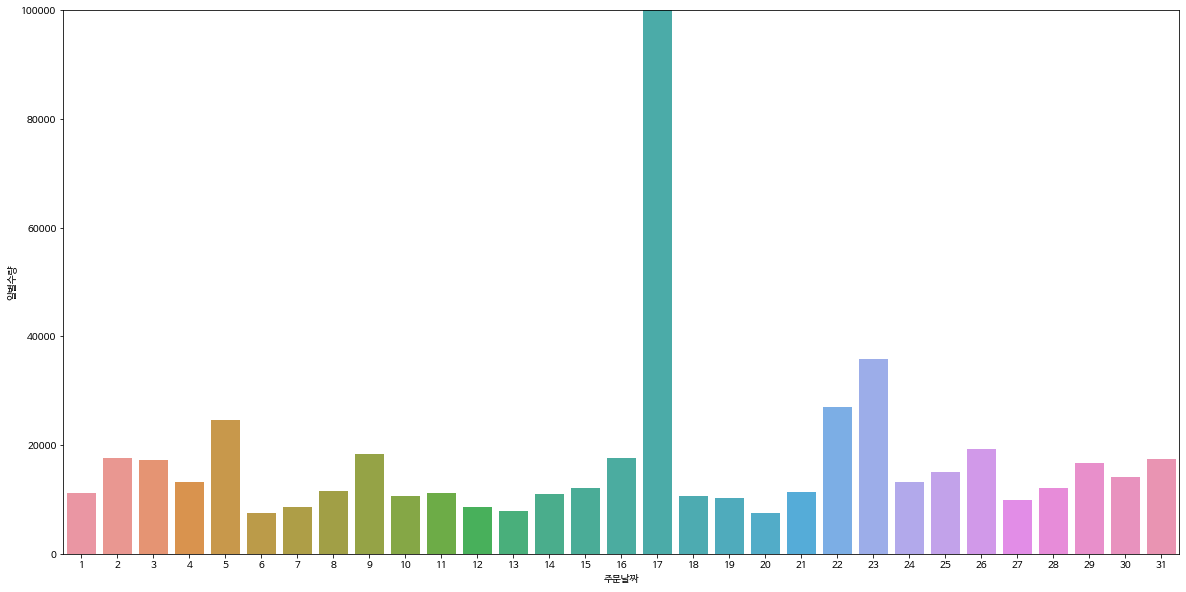

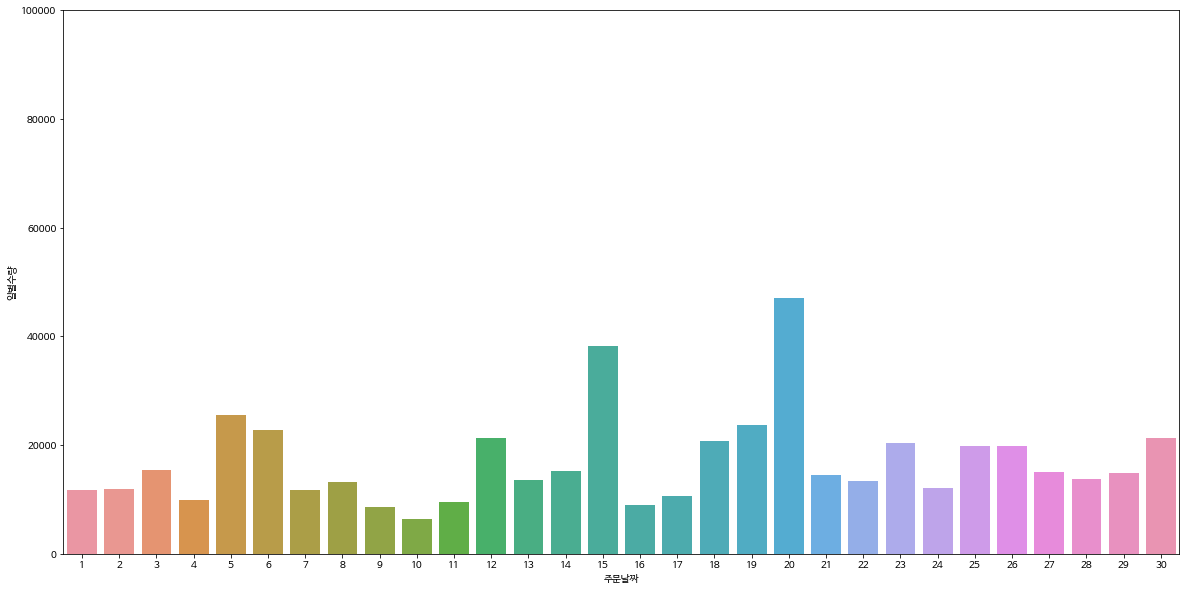

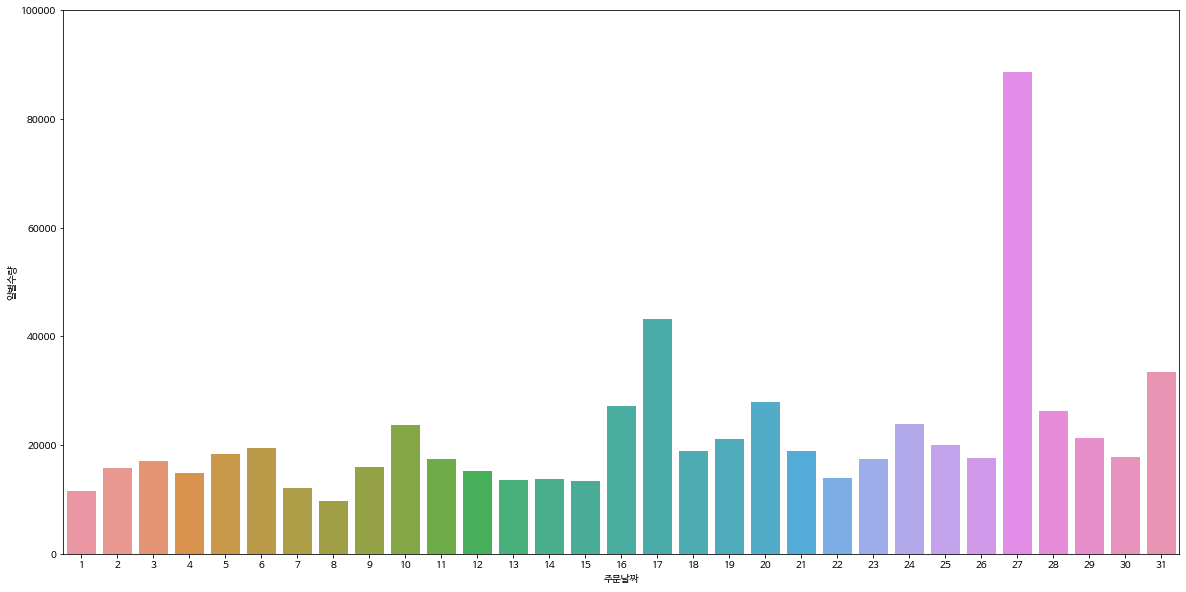

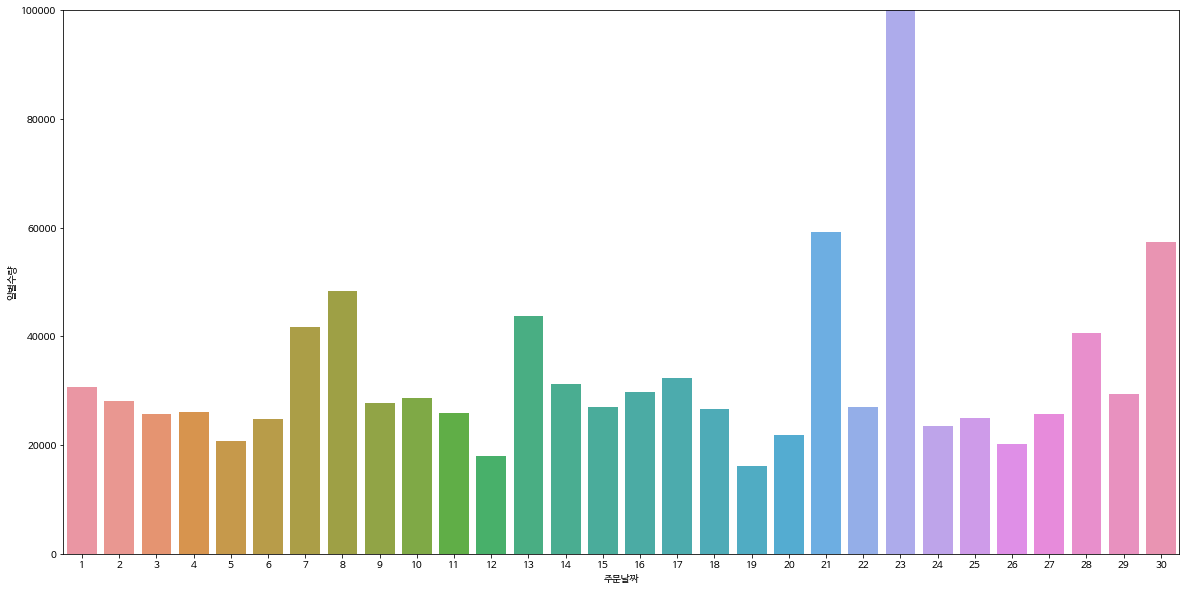

In [12]:
qty_plot(date_3)
qty_plot(date_4)
qty_plot(date_5)
qty_plot(date_6)